# ECOv003 JET Accuracy Analysis with ECOv002 Cal-Val - Calibration Comparison

This notebook compares the accuracy of the JET ensemble using ECOSTRESS Collection 2 Cal-Val data **with and without calibration** applied to air temperature (Ta), relative humidity (RH), and soil moisture (SM).

The notebook shows side-by-side comparisons to demonstrate the impact of calibration on model accuracy.

## Overview

This notebook demonstrates the impact of calibration on JET ensemble model accuracy by:

1. **Processing data twice**: Once without calibration (baseline) and once with calibration applied to meteorological inputs (Ta, RH, SM)
2. **Creating side-by-side comparisons**: All figures show both uncalibrated (left) and calibrated (right) results
3. **Quantifying improvements**: R² and RMSE metrics are shown for both versions to measure calibration effectiveness

The calibration corrects systematic biases in:
- **Air Temperature (Ta_C)**: Temperature measurements from GEOS-5 FP
- **Relative Humidity (RH)**: Humidity measurements from GEOS-5 FP  
- **Soil Moisture (SM)**: Soil moisture measurements from SMAP

## Import Required Libraries and Functions

This cell imports all necessary libraries and functions for data processing, model execution, statistical analysis, and plotting. It includes custom modules for the JET ensemble, sensitivity analysis, and net radiation calculations, as well as standard scientific Python libraries.

In [1]:
import sys
import os
sys.path.insert(0, os.path.abspath(os.path.join(os.path.dirname("__file__"), '..')))
from typing import Callable
from os import makedirs
from os.path import join
import numpy as np
import pandas as pd
from verma_net_radiation import verma_net_radiation_table
from JET3 import process_JET_table, load_ECOv002_calval_JET_inputs
from monte_carlo_sensitivity import perturbed_run, sensitivity_analysis, divide_absolute_by_unperturbed, sensitivity_magnitude_barchart
import matplotlib.pyplot as plt
from scipy.stats import mstats
import seaborn as sns
from matplotlib.ticker import FuncFormatter

## Configuration Options

Set configuration options for the notebook, including whether to save plots to files.

In [2]:
# Configuration: Set to True to save plots to files, False to only display them
SAVE_PLOTS = False

In [3]:
input_variables = [
    "ST_C",
    "NDVI",
    "albedo",
    "Ta_C",
    "RH",
    "AOT",
    "COT",
    "vapor_gccm",
    "ozone_cm",
    "elevation_m",
    "canopy_height_meters"
]

output_variables = [
    "Rn_Wm2",
    "ET_daylight_kg",
    "GPP_inst_g_m2_s"
]

# Per-variable physical bounds to keep perturbations realistic
input_min = {
    "ST_C": 0.0,
    "NDVI": 0.05,
    "albedo": 0.0,
    "Ta_C": 0.0,
    "RH": 0.0,
    "AOT": 0.0,
    "COT": 0.0,
    "vapor_gccm": 0.0,
    "ozone_cm": 0.0,
    "elevation_m": 0.0,
    "canopy_height_meters": 0.0,
}

input_max = {
    "ST_C": 50.0,
    "NDVI": 1,
    "albedo": 1,
}

## Define Processing Function for Model Table

This cell defines the forward process for analysis as the BESS-JPL model.

In [4]:
forward_process = process_JET_table
model_name = "JET"

## Set Normalization Function

This cell assigns the normalization function used to compare perturbed model outputs to the unperturbed baseline. The function `divide_absolute_by_unperturbed` is used for normalization in the sensitivity analysis.

In [5]:
normalization_function = divide_absolute_by_unperturbed

In [6]:
# Define helper function to remove outliers using IQR method
def remove_outliers_iqr(*series_list):
    """
    Remove outliers from multiple aligned Series using IQR method.
    Removes points where ANY of the series exceed Q1-1.5*IQR or Q3+1.5*IQR
    Returns aligned series with outliers removed.
    """
    # Stack all series together to find combined outlier mask
    combined = pd.concat(series_list, axis=1)
    mask = pd.Series(True, index=combined.index)
    
    # For each column, identify outliers
    for col in combined.columns:
        Q1 = combined[col].quantile(0.25)
        Q3 = combined[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        mask &= (combined[col] >= lower_bound) & (combined[col] <= upper_bound)
    
    # Return filtered series
    return tuple(s[mask] for s in series_list)

## Load and Filter Input Data

This cell loads the ECOSTRESS Cal-Val input data using a custom loader function and filters out surface temperatures greater than 50 Celsius and NDVI values less than 0.05. The resulting DataFrame is displayed for inspection.

In [7]:
input_df = load_ECOv002_calval_JET_inputs()

input_df["insitu_RH"] = input_df["RH_percentage"]
input_df["insitu_SM"] = input_df["SM_surf"]

# Apply lower and upper bounds from configuration dictionaries
mask = pd.Series(True, index=input_df.index)
for var, min_val in input_min.items():
    if var in input_df.columns:
        mask &= input_df[var] >= min_val
for var, max_val in input_max.items():
    if var in input_df.columns:
        mask &= input_df[var] <= max_val

input_df = input_df[mask]
input_df = input_df.dropna()
input_df

/var/folders/hk/35_x93nx79vg1zmd2fy1vcbr0000gq/T/ipykernel_1483/2441023809.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  input_df["insitu_SM"] = input_df["SM_surf"]


,Unnamed: 0,ID,vegetation,climate,STICinst,BESSinst,MOD16inst,PTJPLSMinst,ETinst,ETinstUncertainty,...,Tmin_open,Tmin_closed,VPD_open,VPD_closed,Tmin_C,Topt_C,fAPARmax,field_capacity,wilting_point,insitu_SM
15,15,US-xAB,ENF,Csb,141.635670,168.24043,402.81810,159.71700,139.016083,107.183200,...,8.31,-8.0,650.0,3000.0,11.940895,6.69,0.6040,0.33,0.16,0.302400
17,17,US-xAB,ENF,Csb,1.881266,163.94730,301.40400,179.13661,131.273636,106.525215,...,8.31,-8.0,650.0,3000.0,11.940895,6.69,0.6040,0.33,0.16,0.352800
18,18,US-xAB,ENF,Csb,3.135606,246.87700,614.51480,405.50497,366.056641,222.890230,...,8.31,-8.0,650.0,3000.0,11.940895,6.69,0.6040,0.33,0.16,0.389100
19,19,US-xAB,ENF,Csb,311.482820,290.73126,672.27510,478.82382,439.821228,153.787670,...,8.31,-8.0,650.0,3000.0,11.940895,6.69,0.6040,0.33,0.16,0.348350
20,20,US-xAB,ENF,Csb,51.920338,95.28810,116.67136,73.20884,232.693512,24.038680,...,8.31,-8.0,650.0,3000.0,11.940895,6.69,0.6040,0.33,0.16,0.258975
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
992,992,US-xML,DBF,Dfb,417.831120,706.93066,523.92740,310.69684,356.174072,148.624050,...,11.39,-8.0,650.0,3500.0,27.538052,2.66,0.5404,0.34,0.14,0.382250
994,994,US-xML,DBF,Dfb,161.558200,306.15277,420.44678,206.48576,237.659103,98.727560,...,11.39,-8.0,650.0,3500.0,27.538052,2.66,0.5404,0.34,0.14,0.071600
1001,1001,US-UiB,CRO,Dfa,93.876100,251.38747,238.71077,198.90399,106.316444,67.694800,...,12.02,-8.0,650.0,4500.0,9.637029,2.58,0.4060,0.32,0.14,0.341000
1020,1020,US-ARM,CRO,Cfa,80.255005,0.00000,180.10085,211.28325,164.581390,84.672410,...,12.02,-8.0,650.0,4500.0,9.637029,8.48,0.4017,0.29,0.12,0.295767


## Process Input Data Through Model

This cell applies the processing function to the filtered input data, running it through the model, and displays the resulting DataFrame.

In [8]:
# Process data WITHOUT calibration
print("Processing WITHOUT calibration...")
processed_uncalibrated = forward_process(input_df, use_calibration=False)
processed_uncalibrated

# Process data WITH calibration  
print("\nProcessing WITH calibration...")
processed_calibrated = forward_process(input_df, use_calibration=True)
processed_calibrated

Processing WITHOUT calibration...
[2026-02-27 12:20:22 INFO] starting JET table processing
[2026-02-27 12:20:22 INFO] started extracting geometry from JET input table
[2026-02-27 12:20:22 INFO] completed extracting geometry from JET input table (0.004 seconds)
[2026-02-27 12:20:22 INFO] started extracting time from JET input table
[2026-02-27 12:20:22 INFO] completed extracting time from JET input table (0.001 seconds)
[2026-02-27 12:20:22 INFO] running Forest Light Environmental Simulator
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
[2026-02-27 12:20:22 INFO] completed processing FLiES-ANN in 0.15 seconds
[2026-02-27 12:20:22 INFO] variable PAR_albedo min: 0.007 mean: 0.055 max: 0.193 nan: 0.00% (nan)
[2026-02-27 12:20:22 INFO] variable NIR_albedo min: 0.066 mean: 0.162 max: 0.530 nan: 0.00% (nan)
[2026-02-27 12:20:22 INFO] variable PAR_direct_Wm2 min: 7.148 mean: 269.735 max: 442.463 nan: 0.00% (nan)
[2026-02-27 12:20:22 INFO] variable SWin_FLiES_ANN min: 163.676 mean: 716.916 max: 1095.605

,Unnamed: 0,ID,vegetation,climate,STICinst,BESSinst,MOD16inst,PTJPLSMinst,ETinst,ETinstUncertainty,...,ET_daylight_PMJPL_kg,G_PMJPL_Wm2,G_Wm2,LE_instantaneous_Wm2,ET_daylight_kg,ET_uncertainty,GPP_inst_g_m2_s,ET_canopy_inst_kg_m2_s,WUE,AuxiliaryNWP
15,15,US-xAB,ENF,Csb,141.635670,168.24043,402.81810,159.71700,139.016083,107.183200,...,2.801589,24.232924,24.232924,235.004622,3.344676,0.811325,0.000151,0.000100,1.519952,
17,17,US-xAB,ENF,Csb,1.881266,163.94730,301.40400,179.13661,131.273636,106.525215,...,2.783958,13.888571,13.888571,208.788803,3.634896,1.116933,0.000108,0.000072,1.497547,
18,18,US-xAB,ENF,Csb,3.135606,246.87700,614.51480,405.50497,366.056641,222.890230,...,4.063770,33.053500,33.053500,375.255018,4.865916,1.183193,0.000291,0.000173,1.677395,
19,19,US-xAB,ENF,Csb,311.482820,290.73126,672.27510,478.82382,439.821228,153.787670,...,4.385870,42.253985,42.253985,376.522864,4.622162,1.329070,0.000294,0.000204,1.436631,
20,20,US-xAB,ENF,Csb,51.920338,95.28810,116.67136,73.20884,232.693512,24.038680,...,4.020650,2.990681,2.990681,118.701271,3.149331,0.754490,0.000095,0.000010,9.130613,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
992,992,US-xML,DBF,Dfb,417.831120,706.93066,523.92740,310.69684,356.174072,148.624050,...,3.500136,29.141253,29.141253,375.417816,3.438145,0.941759,0.000233,0.000133,1.751269,
994,994,US-xML,DBF,Dfb,161.558200,306.15277,420.44678,206.48576,237.659103,98.727560,...,3.192998,21.272888,21.272888,282.035514,2.848649,1.064079,0.000138,0.000100,1.382509,
1001,1001,US-UiB,CRO,Dfa,93.876100,251.38747,238.71077,198.90399,106.316444,67.694800,...,0.541116,76.673547,76.673547,89.036541,1.108975,1.255443,0.000053,0.000022,2.366093,
1020,1020,US-ARM,CRO,Cfa,80.255005,0.00000,180.10085,211.28325,164.581390,84.672410,...,0.724623,68.376990,68.376990,118.650430,1.399859,1.418580,0.000048,0.000035,1.376374,


Variables requested: ['Ta_C', 'RH', 'SM']
Column mapping per source:
  In-situ: processed_calibrated['insitu_Ta_C'] | Uncalibrated: processed_uncalibrated['Ta_C'] | Calibrated: processed_calibrated['Ta_C']
  In-situ: processed_calibrated['insitu_RH'] | Uncalibrated: processed_uncalibrated['RH'] | Calibrated: processed_calibrated['RH']
  In-situ: processed_calibrated['insitu_SM'] | Uncalibrated: processed_uncalibrated['SM'] | Calibrated: processed_calibrated['SM']

Processing Ta_C (Air Temperature) using in-situ column: insitu_Ta_C


AttributeError: 'NotImplementedType' object has no attribute 'reindex_like'

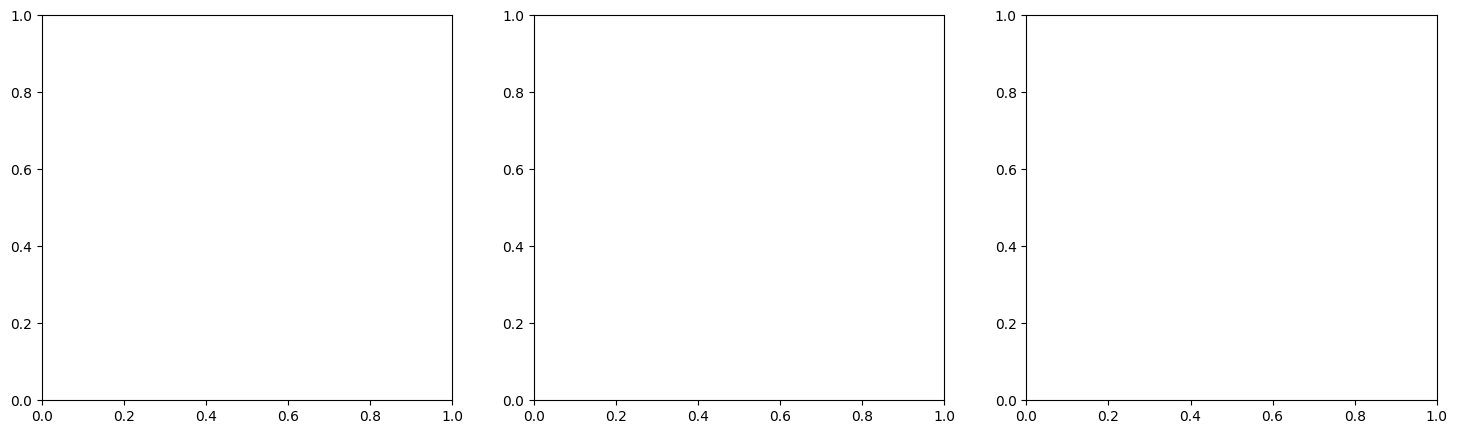

In [9]:
# Create scatter plots comparing in-situ vs uncalibrated/calibrated meteorological variables
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

# Dictionary of variables to compare with their display names and units
met_variables = {
    'Ta_C': {'name': 'Air Temperature', 'unit': '°C', 'xlim': None, 'ylim': None},
    'RH': {'name': 'Relative Humidity', 'unit': '', 'xlim': [0, 1], 'ylim': [0, 1]},
    'SM': {'name': 'Soil Moisture', 'unit': 'm³/m³', 'xlim': [0, 0.6], 'ylim': [0, 0.6]}
}

print("Variables requested:", list(met_variables.keys()))
print("Column mapping per source:")
for var in met_variables.keys():
    insitu_var = f"insitu_{var}"
    print(f"  In-situ: processed_calibrated['{insitu_var}'] | Uncalibrated: processed_uncalibrated['{var}'] | Calibrated: processed_calibrated['{var}']")

# Create one figure with 3 subplots in a row
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for idx, (var, info) in enumerate(met_variables.items()):
    ax = axes[idx]
    insitu_var = f"insitu_{var}"
    print(f"\nProcessing {var} ({info['name']}) using in-situ column: {insitu_var}")
    
    # Check column availability in each dataframe
    missing_sources = []
    if insitu_var not in processed_calibrated.columns:
        missing_sources.append("processed_calibrated (in-situ)")
    if var not in processed_uncalibrated.columns:
        missing_sources.append("processed_uncalibrated")
    if var not in processed_calibrated.columns:
        missing_sources.append("processed_calibrated")

    if missing_sources:
        print(f"Skipping {var}: missing in {', '.join(missing_sources)}")
        continue
    
    # Filter valid data
    valid_idx = (
        processed_calibrated[insitu_var].notna()
        & processed_uncalibrated[var].notna()
        & processed_calibrated[var].notna()
    )
    
    if valid_idx.sum() == 0:
        print(f"No valid data for {var}")
        continue
    
    insitu_vals = processed_calibrated.loc[valid_idx, insitu_var]
    uncal_vals = processed_uncalibrated.loc[valid_idx, var]
    cal_vals = processed_calibrated.loc[valid_idx, var]
    
    # Remove outliers using IQR method
    insitu_vals, uncal_vals, cal_vals = remove_outliers_iqr(insitu_vals, uncal_vals, cal_vals)
    
    print(f"  Data points after outlier removal: {len(insitu_vals)}")
    
    # In-situ (x) vs model values (y)
    ax.scatter(x=insitu_vals, y=uncal_vals, c='red', s=12, alpha=0.6, label='Uncalibrated')
    ax.scatter(x=insitu_vals, y=cal_vals, c='blue', s=12, alpha=0.6, label='Calibrated')
    
    # Calculate metrics against in-situ
    if len(insitu_vals) > 1:
        r2_uncal = r2_score(insitu_vals, uncal_vals)
        rmse_uncal = np.sqrt(mean_squared_error(insitu_vals, uncal_vals))
        mae_uncal = mean_absolute_error(insitu_vals, uncal_vals)
        r2_cal = r2_score(insitu_vals, cal_vals)
        rmse_cal = np.sqrt(mean_squared_error(insitu_vals, cal_vals))
        mae_cal = mean_absolute_error(insitu_vals, cal_vals)
        ax.annotate(
            f"Uncal: $R^2$ = {r2_uncal:.3f} | RMSE = {rmse_uncal:.3f} | MAE = {mae_uncal:.3f}\nCal: $R^2$ = {r2_cal:.3f} | RMSE = {rmse_cal:.3f} | MAE = {mae_cal:.3f}",
            xy=(0.05, 0.95), xycoords='axes fraction',
            ha='left', va='top', fontsize=9,
            bbox=dict(boxstyle='round', fc='white', ec='gray', alpha=0.7)
        )
    
    # 1:1 line
    min_val = min(insitu_vals.min(), uncal_vals.min(), cal_vals.min())
    max_val = max(insitu_vals.max(), uncal_vals.max(), cal_vals.max())
    ax.plot([min_val, max_val], [min_val, max_val], 'k-', linewidth=1, label='1:1 Line')
    
    ax.set_xlabel(f'In-Situ {info["name"]} {info["unit"]}')
    ax.set_ylabel(f'Model {info["name"]} {info["unit"]}')
    ax.set_title(f'{info["name"]}')
    ax.grid(True, alpha=0.3)
    ax.legend()
    
    if info['xlim']:
        ax.set_xlim(info['xlim'])
        ax.set_ylim(info['ylim'])
    
    # Print summary
    print(f"{info['name']} Comparison Summary:")
    print(f"  Mean In-Situ: {insitu_vals.mean():.3f} {info['unit']}")
    print(f"  Mean Uncalibrated: {uncal_vals.mean():.3f} {info['unit']}")
    print(f"  Mean Calibrated: {cal_vals.mean():.3f} {info['unit']}")

plt.suptitle('Meteorological Variables: In-Situ vs Uncalibrated/Calibrated (Outliers Removed)', fontsize=14, y=0.98)

if SAVE_PLOTS:
    plt.savefig('Met_Variables_Insitu_vs_Calibration_Comparison.jpeg', format='jpeg', bbox_inches='tight', dpi=150)
    plt.savefig('Met_Variables_Insitu_vs_Calibration_Comparison.svg', format='svg', bbox_inches='tight')

plt.tight_layout()
plt.show()

In [ ]:
# Scatter plots: Insitu ET and LE vs Calibrated/Uncalibrated
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 7))

# ===== LEFT PLOT: ET =====
insitu_et_var = 'insitu_ET_daylight_kg'
uncal_et_var = 'ET_daylight_kg'
cal_et_var = 'ET_daylight_kg'
print(f"ET variable mapping -> In-situ: processed_calibrated['{insitu_et_var}'] | Uncalibrated: processed_uncalibrated['{uncal_et_var}'] | Calibrated: processed_calibrated['{cal_et_var}']")

# Get valid data for both calibrated and uncalibrated ET
insitu_et = processed_calibrated[insitu_et_var].dropna()
uncal_et = processed_uncalibrated.loc[insitu_et.index, uncal_et_var]
cal_et = processed_calibrated.loc[insitu_et.index, cal_et_var]

# Remove any remaining NaN values
valid_mask = uncal_et.notna() & cal_et.notna()
insitu_et = insitu_et[valid_mask]
uncal_et = uncal_et[valid_mask]
cal_et = cal_et[valid_mask]

# Remove outliers using IQR method
insitu_et, uncal_et, cal_et = remove_outliers_iqr(insitu_et, uncal_et, cal_et)
print(f"ET data points after outlier removal: {len(insitu_et)}")

# Scatter plots
ax1.scatter(insitu_et, uncal_et, c='red', s=30, alpha=0.6, label='Uncalibrated ET')
ax1.scatter(insitu_et, cal_et, c='blue', s=30, alpha=0.6, label='Calibrated ET')

# 1:1 line
min_val = min(insitu_et.min(), uncal_et.min(), cal_et.min())
max_val = max(insitu_et.max(), uncal_et.max(), cal_et.max())
ax1.plot([min_val, max_val], [min_val, max_val], 'k-', linewidth=1, label='1:1 Line')

# OLS regression line for uncalibrated
coefs_uncal = np.polyfit(insitu_et, uncal_et, 1)
ols_x = np.array([min_val, max_val])
ols_y_uncal = coefs_uncal[0] * ols_x + coefs_uncal[1]
ax1.plot(ols_x, ols_y_uncal, 'r--', linewidth=1.5, label='Uncalibrated OLS Fit')

# OLS regression line for calibrated
coefs_cal = np.polyfit(insitu_et, cal_et, 1)
ols_y_cal = coefs_cal[0] * ols_x + coefs_cal[1]
ax1.plot(ols_x, ols_y_cal, 'b--', linewidth=1.5, label='Calibrated OLS Fit')

# Calculate R² and RMSE for both (using regression predictions)
y_pred_uncal = coefs_uncal[0] * insitu_et + coefs_uncal[1]
r2_uncal = r2_score(uncal_et, y_pred_uncal)
rmse_uncal = np.sqrt(mean_squared_error(insitu_et, uncal_et))
mae_uncal = mean_absolute_error(insitu_et, uncal_et)

y_pred_cal = coefs_cal[0] * insitu_et + coefs_cal[1]
r2_cal = r2_score(cal_et, y_pred_cal)
rmse_cal = np.sqrt(mean_squared_error(insitu_et, cal_et))
mae_cal = mean_absolute_error(insitu_et, cal_et)

# Add statistics text box
stats_text = f"Uncalibrated: $R^2$ = {r2_uncal:.3f}, RMSE = {rmse_uncal:.2f}, MAE = {mae_uncal:.2f}\n"
stats_text += f"Calibrated: $R^2$ = {r2_cal:.3f}, RMSE = {rmse_cal:.2f}, MAE = {mae_cal:.2f}"
ax1.annotate(stats_text, xy=(0.05, 0.95), xycoords='axes fraction',
            ha='left', va='top', fontsize=10,
            bbox=dict(boxstyle='round', fc='white', ec='gray', alpha=0.8))

ax1.set_xlabel('In-Situ ET (mm/day)', fontsize=12)
ax1.set_ylabel('Model ET (mm/day)', fontsize=12)
ax1.set_title('In-Situ ET vs Calibrated/Uncalibrated ET', fontsize=14)
ax1.legend(loc='lower right')
ax1.grid(True, alpha=0.3)

# ===== RIGHT PLOT: LE =====
insitu_le_var = 'insitu_LE_Wm2'
uncal_le_var = 'LE_Wm2'
cal_le_var = 'LE_Wm2'
print(f"LE variable mapping -> In-situ: processed_calibrated['{insitu_le_var}'] | Uncalibrated: processed_uncalibrated['{uncal_le_var}'] | Calibrated: processed_calibrated['{cal_le_var}']")

# Get valid data for both calibrated and uncalibrated LE
insitu_le = processed_calibrated[insitu_le_var].dropna()
uncal_le = processed_uncalibrated.loc[insitu_le.index, uncal_le_var]
cal_le = processed_calibrated.loc[insitu_le.index, cal_le_var]

# Remove any remaining NaN values
valid_mask = uncal_le.notna() & cal_le.notna()
insitu_le = insitu_le[valid_mask]
uncal_le = uncal_le[valid_mask]
cal_le = cal_le[valid_mask]

# Remove outliers using IQR method
insitu_le, uncal_le, cal_le = remove_outliers_iqr(insitu_le, uncal_le, cal_le)
print(f"LE data points after outlier removal: {len(insitu_le)}")

# Scatter plots
ax2.scatter(insitu_le, uncal_le, c='red', s=30, alpha=0.6, label='Uncalibrated LE')
ax2.scatter(insitu_le, cal_le, c='blue', s=30, alpha=0.6, label='Calibrated LE')

# 1:1 line
min_val = min(insitu_le.min(), uncal_le.min(), cal_le.min())
max_val = max(insitu_le.max(), uncal_le.max(), cal_le.max())
ax2.plot([min_val, max_val], [min_val, max_val], 'k-', linewidth=1, label='1:1 Line')

# OLS regression line for uncalibrated
coefs_uncal = np.polyfit(insitu_le, uncal_le, 1)
ols_x = np.array([min_val, max_val])
ols_y_uncal = coefs_uncal[0] * ols_x + coefs_uncal[1]
ax2.plot(ols_x, ols_y_uncal, 'r--', linewidth=1.5, label='Uncalibrated OLS Fit')

# OLS regression line for calibrated
coefs_cal = np.polyfit(insitu_le, cal_le, 1)
ols_y_cal = coefs_cal[0] * ols_x + coefs_cal[1]
ax2.plot(ols_x, ols_y_cal, 'b--', linewidth=1.5, label='Calibrated OLS Fit')

# Calculate R² and RMSE for both (using regression predictions)
y_pred_uncal = coefs_uncal[0] * insitu_le + coefs_uncal[1]
r2_uncal = r2_score(uncal_le, y_pred_uncal)
rmse_uncal = np.sqrt(mean_squared_error(insitu_le, uncal_le))
mae_uncal = mean_absolute_error(insitu_le, uncal_le)

y_pred_cal = coefs_cal[0] * insitu_le + coefs_cal[1]
r2_cal = r2_score(cal_le, y_pred_cal)
rmse_cal = np.sqrt(mean_squared_error(insitu_le, cal_le))
mae_cal = mean_absolute_error(insitu_le, cal_le)

# Add statistics text box
stats_text = f"Uncalibrated: $R^2$ = {r2_uncal:.3f}, RMSE = {rmse_uncal:.2f}, MAE = {mae_uncal:.2f}\n"
stats_text += f"Calibrated: $R^2$ = {r2_cal:.3f}, RMSE = {rmse_cal:.2f}, MAE = {mae_cal:.2f}"
ax2.annotate(stats_text, xy=(0.05, 0.95), xycoords='axes fraction',
            ha='left', va='top', fontsize=10,
            bbox=dict(boxstyle='round', fc='white', ec='gray', alpha=0.8))

ax2.set_xlabel('In-Situ LE (W/m²)', fontsize=12)
ax2.set_ylabel('Model LE (W/m²)', fontsize=12)
ax2.set_title('In-Situ LE vs Calibrated/Uncalibrated LE', fontsize=14)
ax2.legend(loc='lower right')
ax2.grid(True, alpha=0.3)

plt.suptitle('In-Situ vs Model: ET and LE Comparison (Outliers Removed)', fontsize=16, y=1.00)
plt.tight_layout()

if SAVE_PLOTS:
    plt.savefig('Insitu_ET_LE_vs_Calibrated_Uncalibrated.jpeg', format='jpeg', bbox_inches='tight', dpi=150)
    plt.savefig('Insitu_ET_LE_vs_Calibrated_Uncalibrated.svg', format='svg', bbox_inches='tight')

plt.show()

## Individual Model Comparisons: ET and LE

Side-by-side comparison of ET (left) and LE (right) for each individual model in the JET ensemble:
- **BESS-JPL**: Breathing Earth System Simulator
- **STIC-JPL**: Surface Temperature Initiated Closure
- **PT-JPL-SM**: Priestley-Taylor with Soil Moisture constraint
- **PM-JPL**: Penman-Monteith

For each model, ET is derived from LE using the latent heat of vaporization (λ ≈ 2.45 MJ/kg).

In [ ]:
# Individual model comparisons: ET and LE side by side for each model
# Models in JET ensemble: BESS, STIC, PT-JPL-SM, PM-JPL

models = [
    {"name": "BESS", "le_col": "LE_BESS_Wm2"},
    {"name": "STIC", "le_col": "LE_STIC_Wm2"},
    {"name": "PT-JPL-SM", "le_col": "LE_PTJPLSM_Wm2"},
    {"name": "PM-JPL", "le_col": "LE_PMJPL_Wm2"}
]

# Latent heat of vaporization (J/kg) at 20°C
lambda_v = 2.45e6  # J/kg

for model_info in models:
    model_name_str = model_info["name"]
    le_col = model_info["le_col"]
    
    print(f"\n{'='*80}")
    print(f"Processing {model_name_str} Model")
    print(f"{'='*80}")
    
    # Check if the LE column exists
    if le_col not in processed_calibrated.columns:
        print(f"Skipping {model_name_str}: {le_col} not found")
        continue
    
    # Print variable mappings for this model
    insitu_et_var = 'insitu_ET_daylight_kg'
    insitu_le_var = 'insitu_LE_Wm2'
    print(f"\nET variable mapping for {model_name_str}:")
    print(f"  In-situ: processed_calibrated['{insitu_et_var}']")
    print(f"  Uncalibrated: processed_uncalibrated['{le_col}'] (converted to ET)")
    print(f"  Calibrated: processed_calibrated['{le_col}'] (converted to ET)")
    print(f"\nLE variable mapping for {model_name_str}:")
    print(f"  In-situ: processed_calibrated['{insitu_le_var}']")
    print(f"  Uncalibrated: processed_uncalibrated['{le_col}']")
    print(f"  Calibrated: processed_calibrated['{le_col}']")
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 7))
    
    # ===== LEFT PLOT: ET (convert from LE) =====
    # Get valid data for both calibrated and uncalibrated ET
    insitu_et = processed_calibrated[insitu_et_var].dropna()
    
    # Convert LE (W/m²) to ET (kg/m²/day = mm/day)
    # LE [W/m²] = LE [J/s/m²]
    # ET [kg/m²/day] = LE [J/s/m²] * 86400 [s/day] / lambda_v [J/kg]
    conversion_factor = 86400 / lambda_v  # Converts W/m² to kg/m²/day (mm/day)
    
    uncal_le = processed_uncalibrated.loc[insitu_et.index, le_col]
    cal_le = processed_calibrated.loc[insitu_et.index, le_col]
    
    uncal_et = uncal_le * conversion_factor
    cal_et = cal_le * conversion_factor
    
    # Remove any remaining NaN values
    valid_mask = uncal_et.notna() & cal_et.notna()
    insitu_et_valid = insitu_et[valid_mask]
    uncal_et_valid = uncal_et[valid_mask]
    cal_et_valid = cal_et[valid_mask]
    
    # Remove outliers using IQR method
    insitu_et_valid, uncal_et_valid, cal_et_valid = remove_outliers_iqr(insitu_et_valid, uncal_et_valid, cal_et_valid)
    print(f"ET data points after outlier removal: {len(insitu_et_valid)}")
    
    if len(insitu_et_valid) > 0:
        # Scatter plots
        ax1.scatter(insitu_et_valid, uncal_et_valid, c='red', s=30, alpha=0.6, label='Uncalibrated ET')
        ax1.scatter(insitu_et_valid, cal_et_valid, c='blue', s=30, alpha=0.6, label='Calibrated ET')
        
        # 1:1 line
        min_val = min(insitu_et_valid.min(), uncal_et_valid.min(), cal_et_valid.min())
        max_val = max(insitu_et_valid.max(), uncal_et_valid.max(), cal_et_valid.max())
        ax1.plot([min_val, max_val], [min_val, max_val], 'k-', linewidth=1, label='1:1 Line')
        
        # OLS regression line for uncalibrated
        coefs_uncal = np.polyfit(insitu_et_valid, uncal_et_valid, 1)
        ols_x = np.array([min_val, max_val])
        ols_y_uncal = coefs_uncal[0] * ols_x + coefs_uncal[1]
        ax1.plot(ols_x, ols_y_uncal, 'r--', linewidth=1.5, label='Uncalibrated OLS Fit')
        
        # OLS regression line for calibrated
        coefs_cal = np.polyfit(insitu_et_valid, cal_et_valid, 1)
        ols_y_cal = coefs_cal[0] * ols_x + coefs_cal[1]
        ax1.plot(ols_x, ols_y_cal, 'b--', linewidth=1.5, label='Calibrated OLS Fit')
        
        # Calculate R² and RMSE for both (using regression predictions)
        y_pred_uncal = coefs_uncal[0] * insitu_et_valid + coefs_uncal[1]
        r2_uncal = r2_score(uncal_et_valid, y_pred_uncal)
        rmse_uncal = np.sqrt(mean_squared_error(insitu_et_valid, uncal_et_valid))
        mae_uncal = mean_absolute_error(insitu_et_valid, uncal_et_valid)
        
        y_pred_cal = coefs_cal[0] * insitu_et_valid + coefs_cal[1]
        r2_cal = r2_score(cal_et_valid, y_pred_cal)
        rmse_cal = np.sqrt(mean_squared_error(insitu_et_valid, cal_et_valid))
        mae_cal = mean_absolute_error(insitu_et_valid, cal_et_valid)
        
        # Add statistics text box
        stats_text = f"Uncalibrated: $R^2$ = {r2_uncal:.3f}, RMSE = {rmse_uncal:.2f}, MAE = {mae_uncal:.2f}\n"
        stats_text += f"Calibrated: $R^2$ = {r2_cal:.3f}, RMSE = {rmse_cal:.2f}, MAE = {mae_cal:.2f}"
        ax1.annotate(stats_text, xy=(0.05, 0.95), xycoords='axes fraction',
                    ha='left', va='top', fontsize=10,
                    bbox=dict(boxstyle='round', fc='white', ec='gray', alpha=0.8))
        
        ax1.set_xlabel('In-Situ ET (mm/day)', fontsize=12)
        ax1.set_ylabel(f'{model_name_str} ET (mm/day)', fontsize=12)
        ax1.set_title(f'In-Situ ET vs {model_name_str} ET', fontsize=14)
        ax1.legend(loc='lower right')
        ax1.grid(True, alpha=0.3)
    
    # ===== RIGHT PLOT: LE =====
    # Get valid data for both calibrated and uncalibrated LE
    insitu_le = processed_calibrated[insitu_le_var].dropna()
    uncal_le = processed_uncalibrated.loc[insitu_le.index, le_col]
    cal_le = processed_calibrated.loc[insitu_le.index, le_col]
    
    # Remove any remaining NaN values
    valid_mask = uncal_le.notna() & cal_le.notna()
    insitu_le_valid = insitu_le[valid_mask]
    uncal_le_valid = uncal_le[valid_mask]
    cal_le_valid = cal_le[valid_mask]
    
    # Remove outliers using IQR method
    insitu_le_valid, uncal_le_valid, cal_le_valid = remove_outliers_iqr(insitu_le_valid, uncal_le_valid, cal_le_valid)
    print(f"LE data points after outlier removal: {len(insitu_le_valid)}")
    
    if len(insitu_le_valid) > 0:
        # Scatter plots
        ax2.scatter(insitu_le_valid, uncal_le_valid, c='red', s=30, alpha=0.6, label='Uncalibrated LE')
        ax2.scatter(insitu_le_valid, cal_le_valid, c='blue', s=30, alpha=0.6, label='Calibrated LE')
        
        # 1:1 line
        min_val = min(insitu_le_valid.min(), uncal_le_valid.min(), cal_le_valid.min())
        max_val = max(insitu_le_valid.max(), uncal_le_valid.max(), cal_le_valid.max())
        ax2.plot([min_val, max_val], [min_val, max_val], 'k-', linewidth=1, label='1:1 Line')
        
        # OLS regression line for uncalibrated
        coefs_uncal = np.polyfit(insitu_le_valid, uncal_le_valid, 1)
        ols_x = np.array([min_val, max_val])
        ols_y_uncal = coefs_uncal[0] * ols_x + coefs_uncal[1]
        ax2.plot(ols_x, ols_y_uncal, 'r--', linewidth=1.5, label='Uncalibrated OLS Fit')
        
        # OLS regression line for calibrated
        coefs_cal = np.polyfit(insitu_le_valid, cal_le_valid, 1)
        ols_y_cal = coefs_cal[0] * ols_x + coefs_cal[1]
        ax2.plot(ols_x, ols_y_cal, 'b--', linewidth=1.5, label='Calibrated OLS Fit')
        
        # Calculate R² and RMSE for both (using regression predictions)
        y_pred_uncal = coefs_uncal[0] * insitu_le_valid + coefs_uncal[1]
        r2_uncal = r2_score(uncal_le_valid, y_pred_uncal)
        rmse_uncal = np.sqrt(mean_squared_error(insitu_le_valid, uncal_le_valid))
        mae_uncal = mean_absolute_error(insitu_le_valid, uncal_le_valid)
        
        y_pred_cal = coefs_cal[0] * insitu_le_valid + coefs_cal[1]
        r2_cal = r2_score(cal_le_valid, y_pred_cal)
        rmse_cal = np.sqrt(mean_squared_error(insitu_le_valid, cal_le_valid))
        mae_cal = mean_absolute_error(insitu_le_valid, cal_le_valid)
        
        # Add statistics text box
        stats_text = f"Uncalibrated: $R^2$ = {r2_uncal:.3f}, RMSE = {rmse_uncal:.2f}, MAE = {mae_uncal:.2f}\n"
        stats_text += f"Calibrated: $R^2$ = {r2_cal:.3f}, RMSE = {rmse_cal:.2f}, MAE = {mae_cal:.2f}"
        ax2.annotate(stats_text, xy=(0.05, 0.95), xycoords='axes fraction',
                    ha='left', va='top', fontsize=10,
                    bbox=dict(boxstyle='round', fc='white', ec='gray', alpha=0.8))
        
        ax2.set_xlabel('In-Situ LE (W/m²)', fontsize=12)
        ax2.set_ylabel(f'{model_name_str} LE (W/m²)', fontsize=12)
        ax2.set_title(f'In-Situ LE vs {model_name_str} LE', fontsize=14)
        ax2.legend(loc='lower right')
        ax2.grid(True, alpha=0.3)
    
    plt.suptitle(f'{model_name_str} Model: In-Situ vs Model ET and LE (Outliers Removed)', fontsize=16, y=1.00)
    plt.tight_layout()
    
    if SAVE_PLOTS:
        plt.savefig(f'Insitu_vs_{model_name_str}_ET_LE_Calibrated_Uncalibrated.jpeg', format='jpeg', bbox_inches='tight', dpi=150)
        plt.savefig(f'Insitu_vs_{model_name_str}_ET_LE_Calibrated_Uncalibrated.svg', format='svg', bbox_inches='tight')
    
    plt.show()
    print(f"\nCompleted {model_name_str} model comparison\n" + "="*80 + "\n")

In [ ]:
# Investigate the relationship between RH error and ET/LE error with and without calibration

# Calculate RH errors (model - in-situ)
rh_error_uncal = processed_uncalibrated['RH'] - processed_uncalibrated['insitu_RH']
rh_error_cal = processed_calibrated['RH'] - processed_calibrated['insitu_RH']

# Calculate ET errors (model - in-situ)
et_error_uncal = processed_uncalibrated['ET_daylight_kg'] - processed_uncalibrated['insitu_ET_daylight_kg']
et_error_cal = processed_calibrated['ET_daylight_kg'] - processed_calibrated['insitu_ET_daylight_kg']

# Calculate LE errors (model - in-situ)
le_error_uncal = processed_uncalibrated['LE_Wm2'] - processed_uncalibrated['insitu_LE_Wm2']
le_error_cal = processed_calibrated['LE_Wm2'] - processed_calibrated['insitu_LE_Wm2']

# Remove outliers from error data
rh_error_uncal, et_error_uncal, le_error_uncal = remove_outliers_iqr(rh_error_uncal, et_error_uncal, le_error_uncal)
rh_error_cal, et_error_cal, le_error_cal = remove_outliers_iqr(rh_error_cal, et_error_cal, le_error_cal)

print(f"Error data points after outlier removal: {len(rh_error_uncal)}")

# Create figure with 2x2 subplots
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# ===== TOP LEFT: RH Error vs ET Error =====
ax = axes[0, 0]
ax.scatter(rh_error_uncal, et_error_uncal, c='red', s=30, alpha=0.6, label='Uncalibrated')
ax.scatter(rh_error_cal, et_error_cal, c='blue', s=30, alpha=0.6, label='Calibrated')
ax.axhline(y=0, color='k', linestyle='--', linewidth=1, alpha=0.5)
ax.axvline(x=0, color='k', linestyle='--', linewidth=1, alpha=0.5)

# Calculate correlations
corr_uncal_et = np.corrcoef(rh_error_uncal, et_error_uncal)[0, 1]
corr_cal_et = np.corrcoef(rh_error_cal, et_error_cal)[0, 1]

stats_text = f"Uncal Correlation: {corr_uncal_et:.3f}\nCal Correlation: {corr_cal_et:.3f}"
ax.annotate(stats_text, xy=(0.05, 0.95), xycoords='axes fraction',
            ha='left', va='top', fontsize=10,
            bbox=dict(boxstyle='round', fc='white', ec='gray', alpha=0.8))

ax.set_xlabel('RH Error (Model - In-Situ)', fontsize=11)
ax.set_ylabel('ET Error (mm/day)', fontsize=11)
ax.set_title('RH Error vs ET Error', fontsize=12, fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)

# ===== TOP RIGHT: RH Error vs LE Error =====
ax = axes[0, 1]
ax.scatter(rh_error_uncal, le_error_uncal, c='red', s=30, alpha=0.6, label='Uncalibrated')
ax.scatter(rh_error_cal, le_error_cal, c='blue', s=30, alpha=0.6, label='Calibrated')
ax.axhline(y=0, color='k', linestyle='--', linewidth=1, alpha=0.5)
ax.axvline(x=0, color='k', linestyle='--', linewidth=1, alpha=0.5)

# Calculate correlations
corr_uncal_le = np.corrcoef(rh_error_uncal, le_error_uncal)[0, 1]
corr_cal_le = np.corrcoef(rh_error_cal, le_error_cal)[0, 1]

stats_text = f"Uncal Correlation: {corr_uncal_le:.3f}\nCal Correlation: {corr_cal_le:.3f}"
ax.annotate(stats_text, xy=(0.05, 0.95), xycoords='axes fraction',
            ha='left', va='top', fontsize=10,
            bbox=dict(boxstyle='round', fc='white', ec='gray', alpha=0.8))

ax.set_xlabel('RH Error (Model - In-Situ)', fontsize=11)
ax.set_ylabel('LE Error (W/m²)', fontsize=11)
ax.set_title('RH Error vs LE Error', fontsize=12, fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)

# ===== BOTTOM LEFT: Absolute RH Error vs Absolute ET Error =====
ax = axes[1, 0]
abs_rh_error_uncal = np.abs(rh_error_uncal)
abs_rh_error_cal = np.abs(rh_error_cal)
abs_et_error_uncal = np.abs(et_error_uncal)
abs_et_error_cal = np.abs(et_error_cal)

ax.scatter(abs_rh_error_uncal, abs_et_error_uncal, c='red', s=30, alpha=0.6, label='Uncalibrated')
ax.scatter(abs_rh_error_cal, abs_et_error_cal, c='blue', s=30, alpha=0.6, label='Calibrated')

# Calculate correlations for absolute errors
corr_uncal_et_abs = np.corrcoef(abs_rh_error_uncal, abs_et_error_uncal)[0, 1]
corr_cal_et_abs = np.corrcoef(abs_rh_error_cal, abs_et_error_cal)[0, 1]

# Calculate mean absolute errors
mae_rh_uncal = abs_rh_error_uncal.mean()
mae_rh_cal = abs_rh_error_cal.mean()
mae_et_uncal = abs_et_error_uncal.mean()
mae_et_cal = abs_et_error_cal.mean()

stats_text = f"Uncal Corr: {corr_uncal_et_abs:.3f} | MAE RH: {mae_rh_uncal:.3f}\n"
stats_text += f"Cal Corr: {corr_cal_et_abs:.3f} | MAE RH: {mae_rh_cal:.3f}\n"
stats_text += f"MAE ET Uncal: {mae_et_uncal:.2f} mm/day\n"
stats_text += f"MAE ET Cal: {mae_et_cal:.2f} mm/day"
ax.annotate(stats_text, xy=(0.05, 0.95), xycoords='axes fraction',
            ha='left', va='top', fontsize=9,
            bbox=dict(boxstyle='round', fc='white', ec='gray', alpha=0.8))

ax.set_xlabel('Absolute RH Error', fontsize=11)
ax.set_ylabel('Absolute ET Error (mm/day)', fontsize=11)
ax.set_title('Absolute RH Error vs Absolute ET Error', fontsize=12, fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)

# ===== BOTTOM RIGHT: Absolute RH Error vs Absolute LE Error =====
ax = axes[1, 1]
abs_le_error_uncal = np.abs(le_error_uncal)
abs_le_error_cal = np.abs(le_error_cal)

ax.scatter(abs_rh_error_uncal, abs_le_error_uncal, c='red', s=30, alpha=0.6, label='Uncalibrated')
ax.scatter(abs_rh_error_cal, abs_le_error_cal, c='blue', s=30, alpha=0.6, label='Calibrated')

# Calculate correlations for absolute errors
corr_uncal_le_abs = np.corrcoef(abs_rh_error_uncal, abs_le_error_uncal)[0, 1]
corr_cal_le_abs = np.corrcoef(abs_rh_error_cal, abs_le_error_cal)[0, 1]

# Calculate mean absolute errors
mae_le_uncal = abs_le_error_uncal.mean()
mae_le_cal = abs_le_error_cal.mean()

stats_text = f"Uncal Corr: {corr_uncal_le_abs:.3f} | MAE RH: {mae_rh_uncal:.3f}\n"
stats_text += f"Cal Corr: {corr_cal_le_abs:.3f} | MAE RH: {mae_rh_cal:.3f}\n"
stats_text += f"MAE LE Uncal: {mae_le_uncal:.2f} W/m²\n"
stats_text += f"MAE LE Cal: {mae_le_cal:.2f} W/m²"
ax.annotate(stats_text, xy=(0.05, 0.95), xycoords='axes fraction',
            ha='left', va='top', fontsize=9,
            bbox=dict(boxstyle='round', fc='white', ec='gray', alpha=0.8))

ax.set_xlabel('Absolute RH Error', fontsize=11)
ax.set_ylabel('Absolute LE Error (W/m²)', fontsize=11)
ax.set_title('Absolute RH Error vs Absolute LE Error', fontsize=12, fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)

plt.suptitle('RH Error vs ET/LE Error: Calibrated vs Uncalibrated (Outliers Removed)', fontsize=14, fontweight='bold', y=0.995)
plt.tight_layout()

if SAVE_PLOTS:
    plt.savefig('RH_Error_vs_ET_LE_Error_Analysis.jpeg', format='jpeg', bbox_inches='tight', dpi=150)
    plt.savefig('RH_Error_vs_ET_LE_Error_Analysis.svg', format='svg', bbox_inches='tight')

plt.show()

# Print summary statistics
print("\n" + "="*80)
print("RH ERROR VS ET/LE ERROR ANALYSIS SUMMARY")
print("="*80)
print("\nRH Error Statistics:")
print(f"  Uncalibrated RH MAE: {mae_rh_uncal:.4f}")
print(f"  Calibrated RH MAE: {mae_rh_cal:.4f}")
print(f"  Improvement: {((mae_rh_uncal - mae_rh_cal) / mae_rh_uncal * 100):.2f}%")

print("\nET Error Statistics:")
print(f"  Uncalibrated ET MAE: {mae_et_uncal:.4f} mm/day")
print(f"  Calibrated ET MAE: {mae_et_cal:.4f} mm/day")
print(f"  Change: {((mae_et_cal - mae_et_uncal) / mae_et_uncal * 100):+.2f}%")

print("\nLE Error Statistics:")
print(f"  Uncalibrated LE MAE: {mae_le_uncal:.4f} W/m²")
print(f"  Calibrated LE MAE: {mae_le_cal:.4f} W/m²")
print(f"  Change: {((mae_le_cal - mae_le_uncal) / mae_le_uncal * 100):+.2f}%")

print("\nCorrelations (RH Error vs ET Error):")
print(f"  Uncalibrated: {corr_uncal_et:.4f}")
print(f"  Calibrated: {corr_cal_et:.4f}")

print("\nCorrelations (RH Error vs LE Error):")
print(f"  Uncalibrated: {corr_uncal_le:.4f}")
print(f"  Calibrated: {corr_cal_le:.4f}")

print("\nCorrelations (Absolute RH Error vs Absolute ET Error):")
print(f"  Uncalibrated: {corr_uncal_et_abs:.4f}")
print(f"  Calibrated: {corr_cal_et_abs:.4f}")

print("\nCorrelations (Absolute RH Error vs Absolute LE Error):")
print(f"  Uncalibrated: {corr_uncal_le_abs:.4f}")
print(f"  Calibrated: {corr_cal_le_abs:.4f}")
print("="*80)